In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import itertools
import pdb

In [4]:
from io import StringIO

In [32]:
colName = ['Class','x-box','ybox','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx'];
data = pd.read_csv('letters_CG.csv',header = 0, names = colName,sep=' ');
data.head()

,Class,x-box,ybox,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,C,4,10,5,8,2,5,7,7,10,7,6,13,1,8,4,9
1,C,3,5,4,4,2,4,8,5,7,12,9,11,1,10,2,7
2,G,5,10,6,7,3,8,7,8,8,6,7,9,2,7,5,10
3,C,5,9,6,7,4,3,8,6,7,12,10,13,1,9,3,7
4,G,4,8,5,6,3,6,6,7,6,10,7,12,2,9,4,9


In [33]:
data.shape

(1509, 17)

In [34]:
pd.isnull(data).sum()

Class    0
x-box    0
ybox     0
width    0
high     0
onpix    0
x-bar    0
y-bar    0
x2bar    0
y2bar    0
xybar    0
x2ybr    0
xy2br    0
x-ege    0
xegvy    0
y-ege    0
yegvx    0
dtype: int64

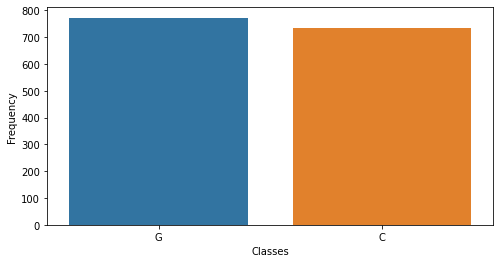

In [35]:
plt.subplots(figsize=(8,4))
sns.barplot(x = data['Class'].value_counts().index, y = data['Class'].value_counts().values);
plt.xlabel('Classes');
plt.ylabel('Frequency');

In [36]:
def Preprocessing(df):
    labels_train = pd.DataFrame();
    features_train = pd.DataFrame();
    labels_test = pd.DataFrame();
    features_test = pd.DataFrame();
    #Seperate features and labels of each class
    for i in range(26):
        labels_class = df.Class[df['Class'] == chr(ord('A') + i)];
        features_class = df[df['Class'] == chr(ord('A') + i)].drop(['Class'], axis = 1);
        index = np.random.permutation(len(labels_class)); #Random Indexes to divide the dataset into train and test
        labels_train = pd.concat([labels_train, labels_class.iloc[index[0:650:1]]]);
        features_train = pd.concat([features_train, features_class.iloc[index[0:650:1]]]);
        labels_test = pd.concat([labels_test, labels_class.iloc[index[650:len(labels_class)]]]);
        features_test = pd.concat([features_test, features_class.iloc[index[650:len(labels_class)]]]);
    #Shuffle the training data
    shuff = np.random.permutation(len(labels_train));
    labels_train = labels_train.iloc[shuff];
    features_train = features_train.iloc[shuff];
    #Shuffle the test data
    shuff = np.random.permutation(len(labels_test));
    labels_test = labels_test.iloc[shuff];
    features_test = features_test.iloc[shuff];

    return labels_train, features_train, labels_test, features_test;

In [38]:
labels_train, features_train, labels_test, features_test = Preprocessing(data);
labels_train.columns = ['Class'];
labels_test.columns = ['Class'];

In [39]:
prior = np.zeros((26,1));

for i in range(26):
    prior[i] = (labels_train == chr(ord('A') + i)).sum()/len(labels_train);

#Seperate the features of each class and find the probability matrix(each feature)
likelihood = np.zeros((26,16));

for i in range(26):
    tidx = labels_train == chr(ord('A') + i);
    temp = features_train[tidx.values];
    likelihood[i,:] = (1 + np.sum(temp,axis = 0))/np.sum(temp).sum();
    
#Classify using Multinomial Naivee Bayes
prob = np.zeros((26,1));
pred = np.ndarray(shape=(len(labels_test),1), dtype=object);

for i in range(len(labels_test)):
    for j in range(26):
        prob[j] = np.log(prior[j]) + np.sum(np.log(likelihood[j,:])*features_test.iloc[i])
    maxIndex = np.argmax(prob);
    pred[i] = chr(ord('A') + maxIndex);

C:\Users\Admin\AppData\Local\Temp\ipykernel_4940\1104170747.py:20: RuntimeWarning: divide by zero encountered in log
  prob[j] = np.log(prior[j]) + np.sum(np.log(likelihood[j,:])*features_test.iloc[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_4940\1104170747.py:20: RuntimeWarning: invalid value encountered in add
  prob[j] = np.log(prior[j]) + np.sum(np.log(likelihood[j,:])*features_test.iloc[i])


In [40]:
acc = np.array(np.sum(labels_test == pred)/len(labels_test))
print('The accuracy for Multinomial Naive Bayes:',np.around(acc[0]*100,decimals=3))

The accuracy for Multinomial Naive Bayes: 0.0


In [41]:
cnf = confusion_matrix(labels_test, pred);cnf

array([[  0,   0,   0],
       [ 86,   0,   0],
       [123,   0,   0]], dtype=int64)

In [42]:
Meu = np.zeros((26,16)) #Calculate the mean for each class and feature
sigma = np.zeros((26,16)) #Calculate the std for each class and feature

for i in range(26):
    tidx = labels_train == chr(ord('A') + i);
    temp = features_train[tidx.values];
    Meu[i,:] = temp.mean()
    sigma[i,:] = temp.std()

check = np.zeros((26,1))
#Now classify the test data
for i in range(len(labels_test)):
    for j in range(26):
        check[j] = prior[j] * np.product(np.exp(-0.5*(np.square(features_test.iloc[i] - Meu[j,:])/np.square(sigma[j,:])))/(np.sqrt(2*np.pi*sigma[j,:])))
    maxIndex = np.argmax(check);
    pred[i] = chr(ord('A') + maxIndex);

In [43]:
acc = np.array(np.sum(labels_test == pred)/len(labels_test))
print('The accuracy for Multinomial Naive Bayes:',np.around(acc[0]*100,decimals=3))

The accuracy for Multinomial Naive Bayes: 78.947


In [44]:
cnf = confusion_matrix(labels_test, pred);cnf

array([[70, 16],
       [28, 95]], dtype=int64)

In [45]:
lh_mul = np.zeros((26,16,16)) #Likelihood of each feature of each class

for i in range(26):
    tidx = labels_train == chr(ord('A') + i);
    temp = features_train[tidx.values];
    shp = temp.shape
    for j in range(16):
        for k in range(16):
            indx = temp.iloc[:,j] == k
            lh_mul[i,j,k] = (1 + indx.sum())/(shp[0]+shp[1])

check = np.zeros((26,1))

for i in range(len(labels_test)):
    for j in range(26):
        temp = 0
        for k in range(16):
            temp = np.log(lh_mul[j,k,features_test.iloc[i,k]])*features_test.iloc[i,k]
            if np.isnan(temp):
                temp = 0
            check[j] = check[j] + temp
        check[j] = np.log(prior[j]) + check[j]
    maxIndex = np.argmax(check);
    pred[i] = chr(ord('A') + maxIndex);
    check[:] = 0 

C:\Users\Admin\AppData\Local\Temp\ipykernel_4940\2046541076.py:22: RuntimeWarning: divide by zero encountered in log
  check[j] = np.log(prior[j]) + check[j]


In [46]:
acc = np.array(np.sum(labels_test == pred)/len(labels_test))
print('The accuracy for Multinomial Naive Bayes:',np.around(acc[0]*100,decimals=3))

The accuracy for Multinomial Naive Bayes: 88.995


In [47]:
cnf = confusion_matrix(labels_test, pred);cnf

array([[ 71,  15],
       [  8, 115]], dtype=int64)

In [48]:
features_train = features_train/15
features_test = features_test/15

In [49]:
def softmax(ar):
    exps = np.exp(ar)
    denom = sum(exps)
    softmax = exps/denom
    return softmax

In [50]:
b = -np.sqrt(6/(16+26)) + 2*np.sqrt(6/(16+26))*np.random.uniform(size = (26,1))
w = -np.sqrt(6/(16+26)) + 2*np.sqrt(6/(16+26))*np.random.uniform(size = (26,16))

#Initialize Variables
epoch = 50
lr = 0.05
alp = 0.35
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db = np.zeros((26,1))   #Gradient for bias
dw = np.zeros((26,16))  #Gradient for weight

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        tot = np.matmul(w,f) + b
        o = softmax(tot)

        #Backward Pass
        db = alp*db + lr*(o-lbl)
        dw = alp*dw + lr*np.matmul((o-lbl),np.transpose(f))
        b = b - db
        w = w - dw

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))
        tot = np.matmul(w,f) + b
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0
    
    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Minimum Error 
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db[:] = 0
    dw[:] = 0

In [51]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3))

Best Accuracy achieved: 94.737


In [52]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[ 79,   7],
       [  8, 115]], dtype=int64)

Text(0, 0.5, 'Cross Entropy Error')

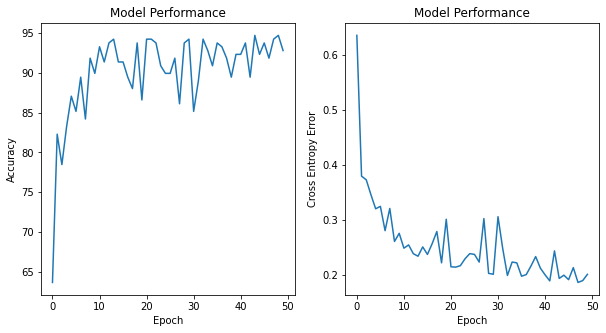

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(50),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(50),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')

In [54]:
hn = 30 #Number of hidden neurons
b1 = -np.sqrt(6/(16+hn)) + 2*np.sqrt(6/(16+hn))*np.random.uniform(size = (hn,1))
w1 = -np.sqrt(6/(16+hn)) + 2*np.sqrt(6/(16+hn))*np.random.uniform(size = (hn,16))
b2 = -np.sqrt(6/(26+hn)) + 2*np.sqrt(6/(26+hn))*np.random.uniform(size = (26,1))
w2 = -np.sqrt(6/(26+hn)) + 2*np.sqrt(6/(26+hn))*np.random.uniform(size = (26,hn))

#Initialize Variables
epoch = 100
lr = 0.1
alp = 0.2
lbl = np.zeros((26,1))
err = np.zeros((epoch,1))
acc = np.zeros((epoch,1))
db1 = np.zeros((hn,1))   #Gradient for bias
dw1 = np.zeros((hn,16))  #Gradient for weight
db2 = np.zeros((26,1))
dw2 = np.zeros((26,hn))

#Temp variables to save best parameters
min_err = np.Inf
max_acc = 0
bpred = np.zeros((len(labels_test),1))

for i in range(epoch):
    shuff = np.random.permutation(len(labels_train))
    #Pass over an epoch
    for j in range(len(labels_train)):
        cls = labels_train.iloc[shuff[j]]
        lbl[ord(cls[0]) - 65] = 1    #One hot encoding

        #Forward Pass
        f = np.reshape(np.array(features_train.iloc[shuff[j]]),(16,1)) #Feature needs to be reshaped due to numpy default behaviour
        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        tot = np.matmul(w2,o1) + b2
        o = softmax(tot)

        #Backward Pass (Might be a little confusing, so try doing the steps on a small matrix)
        db2 = alp*db2 + lr*(o-lbl)
        dw2 = alp*dw2+ lr*np.matmul((o-lbl),np.transpose(o1))
        db1 = alp*db1 + np.transpose(lr*np.matmul(np.transpose(o-lbl),w2))*o1*(1-o1)
        dw1 = alp*dw1 + np.matmul((np.transpose(lr*np.matmul(np.transpose(o-lbl),w2))*o1*(1-o1)),np.transpose(f))

        b1 = b1 - db1
        w1 = w1 - dw1
        b2 = b2 - db2
        w2 = w2 - dw2

        lbl[:] = 0
    
    #Check performance on test set
    for k in range(len(labels_test)):
        cls = labels_test.iloc[k]
        lbl[ord(cls[0]) - 65] = 1
        f = np.reshape(np.array(features_test.iloc[k]),(16,1))

        l1 = np.matmul(w1,f) + b1
        o1 = 1/(1 + np.exp(-l1)) #Sigmoid
        tot = np.matmul(w2,o1) + b2
        o = softmax(tot)

        maxIdx = np.argmax(o)
        pred[k] = chr(ord('A') + maxIdx)

        if pred[k] == cls[0]:
            acc[i] = acc[i] + 1

        entropy = -lbl*np.log(o)
        entropy = np.nan_to_num(entropy)
        err[i] = err[i] + np.sum(entropy)
        lbl[:] = 0

    #print('Epoch:', i, 'Accuracy:', acc[i]/len(labels_test)*100, 'Cross Entropy Error:', err[i]/len(labels_test))
    #Early Stopping condition
    if (err[i] < min_err):
        min_err = err[i]
        bpred = pred

    #Set gradient and labels back to zero
    lbl[:] = 0
    db1[:] = 0
    dw1[:] = 0
    db2[:] = 0
    dw2[:] = 0

In [55]:
print('Best Accuracy achieved:',np.around(np.max(acc)/len(labels_test)*100,decimals=3)) 

Best Accuracy achieved: 98.565


In [56]:
cnf = confusion_matrix(labels_test, bpred);cnf

array([[ 83,   3],
       [  1, 122]], dtype=int64)

Text(0, 0.5, 'Cross Entropy Error')

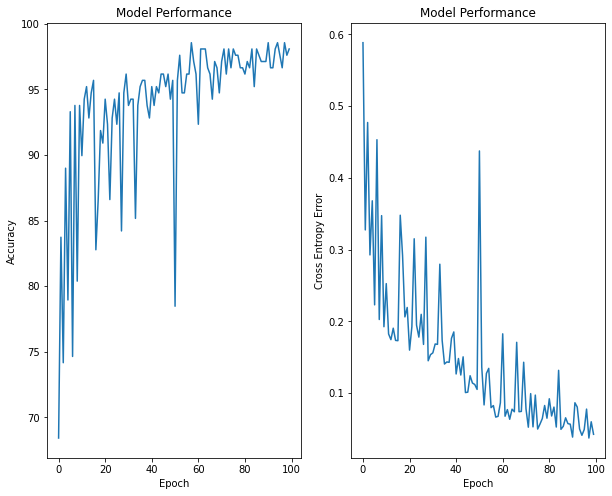

In [57]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.plot(np.arange(100),acc/len(labels_test)*100)
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(122)
plt.plot(np.arange(100),err/len(labels_test))
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')